# Inbalanced Classes
## In this lab, we are going to explore a case of imbalanced classes. 


Like we disussed in class, when we have noisy data, if we are not careful, we can end up fitting our model to the noise in the data and not the 'signal'-- the factors that actually determine the outcome. This is called overfitting, and results in good results in training, and in bad results when the model is applied to real data. Similarly, we could have a model that is too simplistic to accurately model the signal. This produces a model that doesnt work well (ever). 


### Note: before doing the first commit, make sure you don't include the large csv file, either by adding it to .gitignore, or by deleting it.

### First, download the data from: https://www.kaggle.com/ntnu-testimon/paysim1. Import the dataset and provide some discriptive statistics and plots. What do you think will be the important features in determining the outcome?
### Note: don't use the entire dataset, use a sample instead, with n=100000 elements, so your computer doesn't freeze.

In [1]:
# Your code here

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
fraud = pd.read_csv('fraud.csv')

In [3]:
fraud = fraud.sample(n=100000)

In [4]:
fraud.dtypes

step                int64
type               object
amount            float64
nameOrig           object
oldbalanceOrg     float64
newbalanceOrig    float64
nameDest           object
oldbalanceDest    float64
newbalanceDest    float64
isFraud             int64
isFlaggedFraud      int64
dtype: object

In [5]:
fraud.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,100000.000000,1.000000e+05,1.000000e+05,1.000000e+05,1.000000e+05,1.000000e+05,100000.000000,100000.0
mean,243.969070,1.810002e+05,8.377675e+05,8.587763e+05,1.088618e+06,1.213251e+06,0.001570,0.0
std,142.375635,6.034079e+05,2.893938e+06,2.930882e+06,3.244775e+06,3.530057e+06,0.039592,0.0
min,1.000000,6.100000e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.0
25%,156.000000,1.340131e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.0
50%,240.000000,7.522044e+04,1.444000e+04,0.000000e+00,1.281136e+05,2.100425e+05,0.000000,0.0
75%,335.000000,2.085017e+05,1.068142e+05,1.429906e+05,9.370363e+05,1.109069e+06,0.000000,0.0
max,743.000000,4.950709e+07,3.435927e+07,3.440065e+07,1.856415e+08,1.856159e+08,1.000000,0.0


In [6]:
fraud['isFraud'].value_counts()

0    99843
1      157
Name: isFraud, dtype: int64

In [7]:
fraud['isFlaggedFraud'].value_counts()

0    100000
Name: isFlaggedFraud, dtype: int64

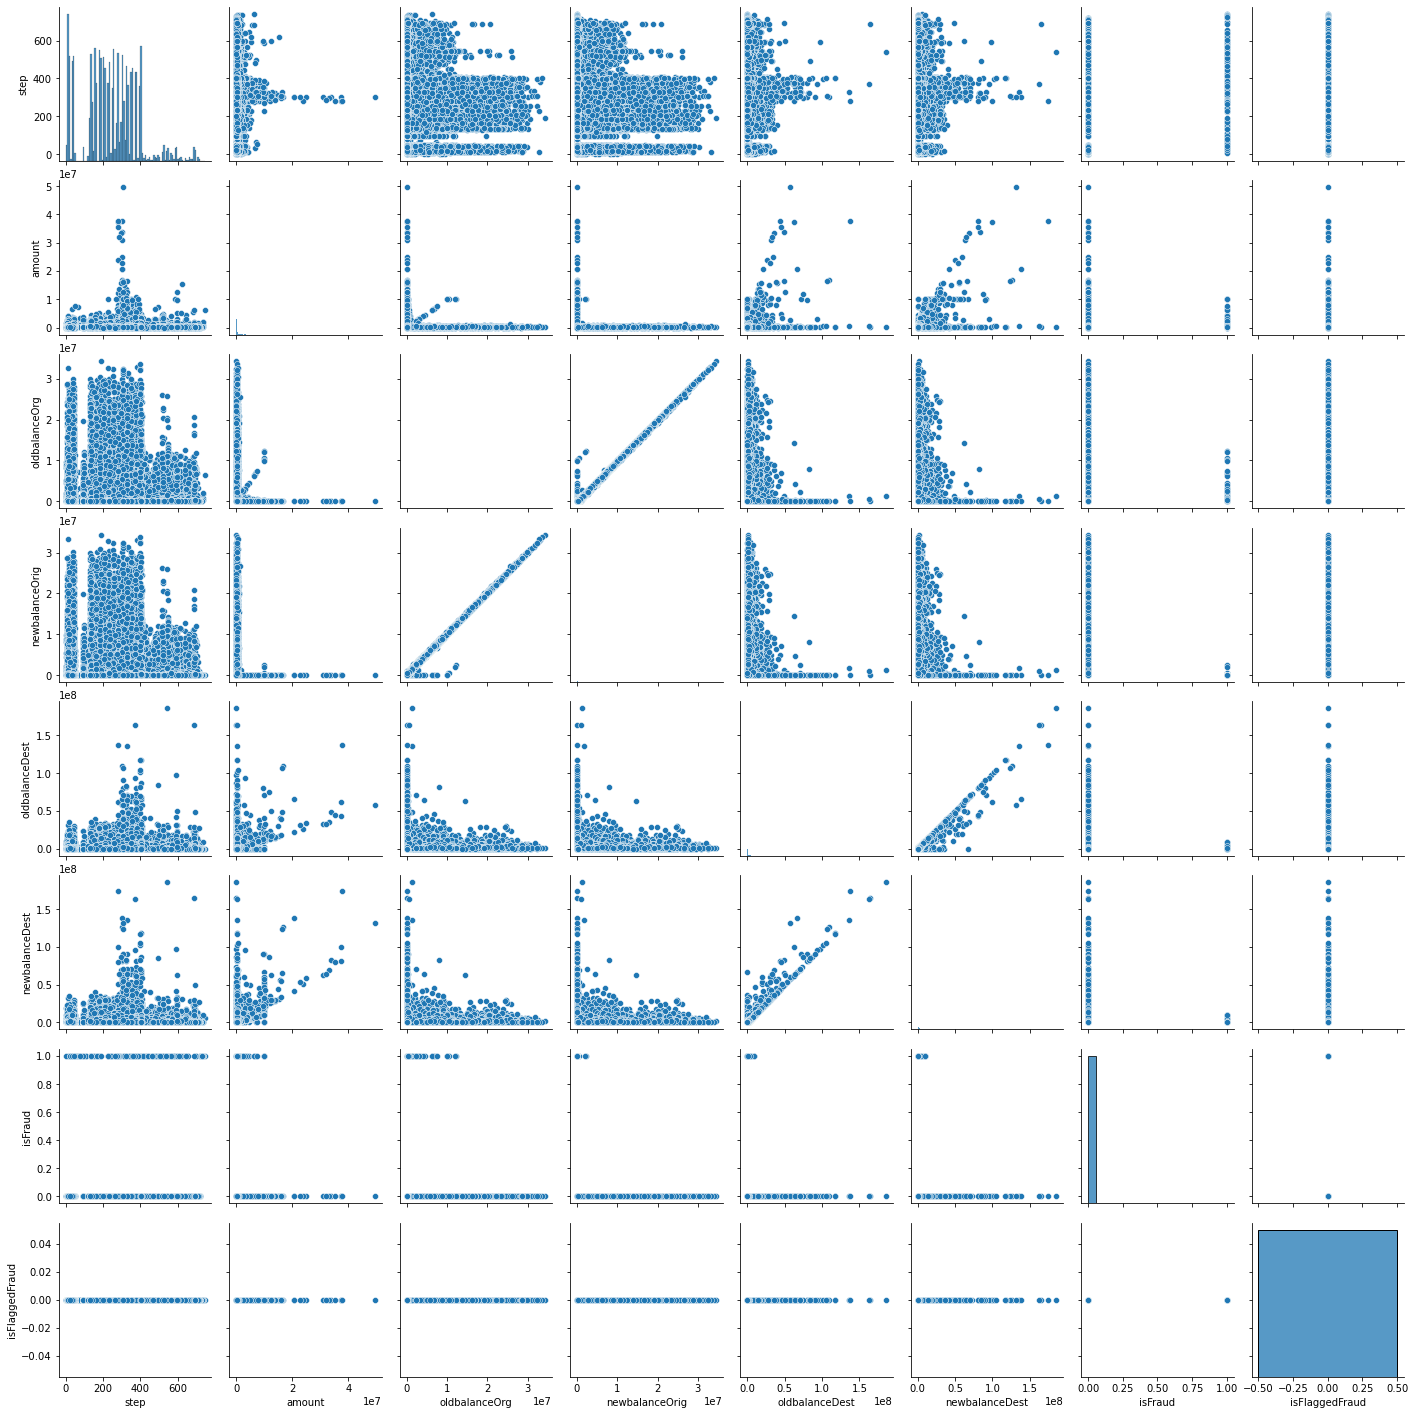

In [8]:
sns.pairplot(fraud)

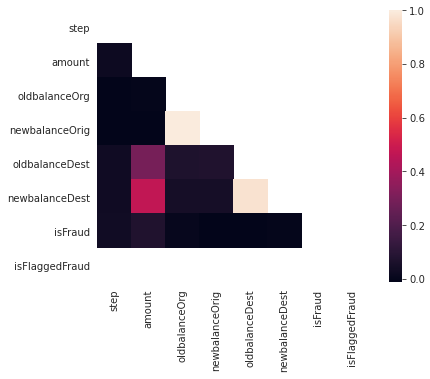

In [9]:
corr = fraud.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(7, 5))
    ax = sns.heatmap(corr, mask=mask, vmax=1, square=True)

In [10]:
# The important features for determing the outcome are amount, odbalancedest, newbalancedest

### What is the distribution of the outcome? 

<AxesSubplot:>

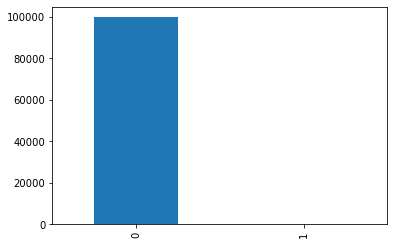

In [11]:
count_classes = pd.value_counts(fraud['isFraud'])
count_classes.plot(kind = 'bar')

### Clean the dataset. How are you going to integrate the time variable? Do you think the step (integer) coding in which it is given is appropriate?

In [86]:
# Your code here

fraud['step'].value_counts()


18     786
19     785
187    775
307    754
355    739
      ... 
494      1
365      1
464      1
720      1
111      1
Name: step, Length: 477, dtype: int64

In [87]:
# i think the step can be changed into week days:

# monday - 1 - 23
# tuesday - 24 - 47
# wendsday - 48 - 73
# thursday - 74 - 97
# friday - 100 - 123
# saturday - 124 - 147
# monday - 148 - 171


In [88]:
days = range(1,31)
fraud['days'] = pd.cut(fraud['step'], 30, labels=days)

In [89]:
fraud[(fraud['step'] > 250 ) & (fraud['step'] < 350)]

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,days,hour,week_days
4274440,307,PAYMENT,12756.98,C1720361613,0.00,0.00,M985754433,0.00,0.00,0,0,13,Night,Saturday
3321585,253,DEBIT,3982.03,C1781464849,0.00,0.00,C774764649,238830.68,242812.71,0,0,11,Afternoon,Thursday
4904059,349,CASH_IN,254492.79,C1689347301,16288.00,270780.79,C1866739026,147699.73,0.00,0,0,15,Afternoon,Monday
4809311,346,CASH_IN,211451.95,C1569519242,683875.67,895327.62,C162346026,435215.47,223763.51,0,0,14,Morning,Sunday
4224993,306,PAYMENT,12024.50,C1150855484,33646.00,21621.50,M1561868616,0.00,0.00,0,0,13,Afternoon,Saturday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3716519,278,TRANSFER,43313.79,C2053356067,52985.00,9671.21,C1023879244,963888.63,1007202.42,0,0,12,Afternoon,Friday
4150809,303,CASH_OUT,97469.64,C1267000311,0.00,0.00,C1050977139,2143774.36,2241244.00,0,0,13,Afternoon,Saturday
4527356,326,CASH_OUT,314541.39,C1226571502,80437.00,0.00,C645450359,440024.77,754566.17,0,0,14,Afternoon,Sunday
4174726,304,CASH_OUT,144014.88,C322344750,32.00,0.00,C254282741,2603886.47,2747901.35,0,0,13,Afternoon,Saturday


In [90]:
def hour(row):
    number = row%24
    if number in list(range(0,13)):
        return 'Morning'
    elif number in list(range(13,19)):
        return 'Afternoon'
    else:
        return 'Night'

In [91]:
fraud['hour'] = fraud['step'].apply(hour)
fraud.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,days,hour,week_days
5409148,378,TRANSFER,797570.47,C476038043,0.0,0.00,C1772004024,1478636.71,2276207.18,0,0,16,Afternoon,Tuesday
5037116,354,CASH_OUT,314867.13,C1918932906,0.0,0.00,C1661029237,1167947.72,1482814.85,0,0,15,Afternoon,Monday
2806219,225,CASH_OUT,216759.73,C952676313,1268.0,0.00,C1733783178,750135.25,966894.97,0,0,10,Morning,Wednesday
715519,37,PAYMENT,10213.69,C1512973802,0.0,0.00,M1207441283,0.00,0.00,0,0,2,Afternoon,Tuesday
187599,13,DEBIT,3815.46,C1701007197,33137.0,29321.54,C883229197,68297.04,42341.78,0,0,1,Afternoon,Monday


In [92]:
fraud['days'].describe()

count     100000
unique        30
top            1
freq        8940
Name: days, dtype: int64

In [93]:
def week_days(row):
    number = row%7
    if number == 1:
        return 'Monday'
    elif number == 2:
        return 'Tuesday'
    elif number == 3:
        return 'Wednesday'
    elif number == 4:
        return 'Thursday'
    elif number == 5:
        return 'Friday'
    elif number == 6:
        return 'Saturday'
    else:
        return 'Sunday'

In [94]:
fraud['week_days'] = fraud['days'].apply(week_days)
fraud.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,days,hour,week_days
5409148,378,TRANSFER,797570.47,C476038043,0.0,0.00,C1772004024,1478636.71,2276207.18,0,0,16,Afternoon,Tuesday
5037116,354,CASH_OUT,314867.13,C1918932906,0.0,0.00,C1661029237,1167947.72,1482814.85,0,0,15,Afternoon,Monday
2806219,225,CASH_OUT,216759.73,C952676313,1268.0,0.00,C1733783178,750135.25,966894.97,0,0,10,Morning,Wednesday
715519,37,PAYMENT,10213.69,C1512973802,0.0,0.00,M1207441283,0.00,0.00,0,0,2,Afternoon,Tuesday
187599,13,DEBIT,3815.46,C1701007197,33137.0,29321.54,C883229197,68297.04,42341.78,0,0,1,Afternoon,Monday


In [95]:
clean_fraud = fraud.drop(columns=['step','nameOrig','nameDest','isFlaggedFraud','days'])
clean_fraud.head()

,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,hour,week_days
5409148,TRANSFER,797570.47,0.0,0.00,1478636.71,2276207.18,0,Afternoon,Tuesday
5037116,CASH_OUT,314867.13,0.0,0.00,1167947.72,1482814.85,0,Afternoon,Monday
2806219,CASH_OUT,216759.73,1268.0,0.00,750135.25,966894.97,0,Morning,Wednesday
715519,PAYMENT,10213.69,0.0,0.00,0.00,0.00,0,Afternoon,Tuesday
187599,DEBIT,3815.46,33137.0,29321.54,68297.04,42341.78,0,Afternoon,Monday


In [96]:
fraud_dummy = pd.get_dummies(clean_fraud, columns=['type','week_days','hour'])
fraud_dummy.head()

,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,...,week_days_Friday,week_days_Monday,week_days_Saturday,week_days_Sunday,week_days_Thursday,week_days_Tuesday,week_days_Wednesday,hour_Afternoon,hour_Morning,hour_Night
5409148,797570.47,0.0,0.00,1478636.71,2276207.18,0,0,0,0,0,...,0,0,0,0,0,1,0,1,0,0
5037116,314867.13,0.0,0.00,1167947.72,1482814.85,0,0,1,0,0,...,0,1,0,0,0,0,0,1,0,0
2806219,216759.73,1268.0,0.00,750135.25,966894.97,0,0,1,0,0,...,0,0,0,0,0,0,1,0,1,0
715519,10213.69,0.0,0.00,0.00,0.00,0,0,0,0,1,...,0,0,0,0,0,1,0,1,0,0
187599,3815.46,33137.0,29321.54,68297.04,42341.78,0,0,0,1,0,...,0,1,0,0,0,0,0,1,0,0


In [97]:
from sklearn.preprocessing import MinMaxScaler

norm = MinMaxScaler().fit(fraud_dummy).transform(fraud_dummy)

norm = pd.DataFrame(norm, columns = fraud_dummy.columns)

norm.head()


,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,...,week_days_Friday,week_days_Monday,week_days_Saturday,week_days_Sunday,week_days_Thursday,week_days_Tuesday,week_days_Wednesday,hour_Afternoon,hour_Morning,hour_Night
0,0.016110,0.000000,0.000000,0.007965,0.012263,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
1,0.006360,0.000000,0.000000,0.006291,0.007989,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.004378,0.000037,0.000000,0.004041,0.005209,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
3,0.000206,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
4,0.000077,0.000964,0.000852,0.000368,0.000228,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


### Run a logisitc regression classifier and evaluate its accuracy.

In [98]:
# Your code here

from sklearn.model_selection import train_test_split

X = norm.drop(columns='isFraud')

y = norm['isFraud']

X_train, X_test, y_train, y_test = train_test_split(X, y,random_state = 0, test_size = 0.20)


In [99]:
from sklearn.utils import resample

train = pd.concat([X_train, y_train],axis=1)
train.head()

,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER,...,week_days_Monday,week_days_Saturday,week_days_Sunday,week_days_Thursday,week_days_Tuesday,week_days_Wednesday,hour_Afternoon,hour_Morning,hour_Night,isFraud
10382,5.051880e-03,0.131478,0.138590,0.002814,0.001467,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
73171,3.977648e-03,0.021540,0.027239,0.024320,0.023263,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
30938,2.290095e-03,0.000298,0.003593,0.001130,0.000520,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
99310,1.344840e-02,0.000000,0.000000,0.003906,0.007933,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
58959,8.006934e-07,0.007918,0.007907,0.000000,0.000000,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


In [100]:
no_fraud = train[train['isFraud']==0]
yes_fraud = train[train['isFraud']==1]

In [101]:
yes_fraud_oversampled = resample(yes_fraud, #<- sample from here
                                    replace=True, #<- we need replacement, since we don't have enough data otherwise
                                    n_samples = len(no_fraud),#<- make both sets the same size
                                    random_state=0)

In [102]:
no_fraud_undersampled = resample(no_fraud, #<- downsample from here
                                    replace=False, #<- no need to reuse data now, we have an abundance
                                    n_samples = len(yes_fraud),
                                    random_state=0)

In [103]:
display(no_fraud.shape)
display(yes_fraud_oversampled.shape)

(79873, 21)

(79873, 21)

In [104]:
display(yes_fraud.shape)
display(no_fraud_undersampled.shape)

(127, 21)

(127, 21)

In [105]:
train_oversampled = pd.concat([no_fraud,yes_fraud_oversampled])
train_oversampled.head()

,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER,...,week_days_Monday,week_days_Saturday,week_days_Sunday,week_days_Thursday,week_days_Tuesday,week_days_Wednesday,hour_Afternoon,hour_Morning,hour_Night,isFraud
10382,5.051880e-03,0.131478,0.138590,0.002814,0.001467,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
73171,3.977648e-03,0.021540,0.027239,0.024320,0.023263,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
30938,2.290095e-03,0.000298,0.003593,0.001130,0.000520,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
99310,1.344840e-02,0.000000,0.000000,0.003906,0.007933,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
58959,8.006934e-07,0.007918,0.007907,0.000000,0.000000,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


In [106]:
train_undersampled = pd.concat([yes_fraud,no_fraud_undersampled])
train_undersampled.head()

,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER,...,week_days_Monday,week_days_Saturday,week_days_Sunday,week_days_Thursday,week_days_Tuesday,week_days_Wednesday,hour_Afternoon,hour_Morning,hour_Night,isFraud
51550,0.020160,0.029049,0.0,0.002374,0.007752,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
50561,0.003191,0.004598,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
46548,0.004192,0.006040,0.0,0.000000,0.001118,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
58953,0.000963,0.001387,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
54126,0.000962,0.001385,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0


In [107]:
y_train_over = train_oversampled['isFraud'].copy()
X_train_over = train_oversampled.drop('isFraud',axis = 1).copy()

In [108]:
y_train_under = train_undersampled['isFraud'].copy()
X_train_under = train_undersampled.drop('isFraud',axis = 1).copy()

In [109]:
# oversampled

from sklearn.linear_model import LogisticRegression

model = LogisticRegression()

fraud_model = model.fit(X_train_over, y_train_over)

C:\Users\DELL\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [110]:
from sklearn.metrics import confusion_matrix, accuracy_score

y_pred = fraud_model.predict(X_test)

print(confusion_matrix(y_test,y_pred))
print(accuracy_score(y_test,y_pred))

[[17098  2872]
 [    3    27]]
0.85625


In [111]:
print("test data accuracy was ",fraud_model.score(X_test,y_test))

print("train data accuracy was ", fraud_model.score(X_train, y_train))

test data accuracy was  0.85625
train data accuracy was  0.85425


In [112]:
from sklearn.metrics import precision_score, recall_score, f1_score

pred = fraud_model.predict(X_test)

print("precision: ",precision_score(y_test,pred))
print("recall: ",recall_score(y_test,pred))
print("f1: ",f1_score(y_test,pred))

precision:  0.009313556398758192
recall:  0.9
f1:  0.018436326391259816


In [113]:
# undersampled

model = LogisticRegression()

fraud_model = model.fit(X_train_under, y_train_under)

In [114]:
y_pred = fraud_model.predict(X_test)

print(confusion_matrix(y_test,y_pred))
print(accuracy_score(y_test,y_pred))

[[14771  5199]
 [    3    27]]
0.7399


In [115]:
print("test data accuracy was ",fraud_model.score(X_test,y_test))

print("train data accuracy was ", fraud_model.score(X_train, y_train))

test data accuracy was  0.7399
train data accuracy was  0.7383375


In [116]:
pred = fraud_model.predict(X_test)

print("precision: ",precision_score(y_test,pred))
print("recall: ",recall_score(y_test,pred))
print("f1: ",f1_score(y_test,pred))

precision:  0.005166475315729047
recall:  0.9
f1:  0.010273972602739727


In [117]:
# SMOTE

from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state =1,sampling_strategy=1.0)
X_train_SMOTE,y_train_SMOTE = sm.fit_sample(X_train,y_train)

LR = LogisticRegression(max_iter=1000)
LR.fit(X_train_SMOTE, y_train_SMOTE)
pred = LR.predict(X_test)

print(confusion_matrix(y_test,pred))
print("precision: ",precision_score(y_test,pred))
print("recall: ",recall_score(y_test,pred))
print("f1: ",f1_score(y_test,pred))

[[17306  2664]
 [    3    27]]
precision:  0.010033444816053512
recall:  0.9
f1:  0.019845644983461964


### Now pick a model of your choice and evaluate its accuracy.

In [118]:
# Your code here

from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier(max_depth = 5)
model.fit(X_train_SMOTE, y_train_SMOTE)

print("test data accuracy was ",model.score(X_test,y_test))
print("train data accuracy was ",model.score(X_train,y_train))




test data accuracy was  0.95785
train data accuracy was  0.958


In [119]:
pred = model.predict(X_test)

print(confusion_matrix(y_test,pred))
print(accuracy_score(y_test,pred))


print("precision: ",precision_score(y_test,pred))
print("recall: ",recall_score(y_test,pred))
print("f1: ",f1_score(y_test,pred))

[[19129   841]
 [    2    28]]
0.95785
precision:  0.03222094361334868
recall:  0.9333333333333333
f1:  0.062291434927697446


### Which model worked better and how do you know?

In [120]:
# Your response here


# the logistic regression with the undersampling method got a satisfatory result.
# 3 fraudulent passed by and we bothered 5000 non fraudulent people.

# logistic regression - undersample
# [[14771  5199]
#  [    3    27]]
# 0.7399
# precision:  0.005166475315729047
# recall:  0.9
# f1:  0.010273972602739727

# the model of the randomforest and SMOTE sampling method lets go only 2 fraudulent, and only bothers 850.


# decisions tree - SMOTE
# [[19113   857]
#  [    2    28]]
# 0.95705
# precision:  0.031638418079096044
# recall:  0.9333333333333333
# f1:  0.06120218579234972

# so by that i can conclude that the randomforest its a better model.

### Note: before doing the first commit, make sure you don't include the large csv file, either by adding it to .gitignore, or by deleting it.